# UNIFIED PARSING SCRIPT USING MACHINE LEARNING
## INNOVATION PRACTICES
### BY
#### 19Z307 - BARATH KUMAR G
#### 19Z335 - NIRANJAN S
#### 19Z347 - SHASHAANK R
#### 19Z358 - TARUN VISVA R
#### 20Z462 - MUKESH S
#### 20Z465 - SRINIVASAN G
### GUIDED BY
#### DR. SUDHA SADHASIVAM G

## HEADERS & LIBRARIES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 http://archive.ubuntu.co

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import ast
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

## MODEL

In [4]:
class Unified_Parsing_Script:
  def __init__(self):
    self.frame = []
    self.tags = dict()
    self.area = dict()

  def extract_info_from_df(self, df):
    f_products = []

    for index, row in df.iterrows():
      product_info = dict()

      p_name = row['product_name']
      body_d = ast.literal_eval(row['body_dimension'])
      name_d = ast.literal_eval(row['name_dimension'])

      product_info['product_name'] = p_name
      product_info['body_dimension'] = body_d
      product_info['name_dimension'] = name_d

      f_products.append(product_info)
    
    return f_products

  def fix_starting_locations(self, products):
    for i in range(len(products)):
      if products[i]['body_dimension']['x'] != 0 or products[i]['body_dimension']['y'] != 0:
        products[i]['name_dimension']['x'] -= products[i]['body_dimension']['x']
        products[i]['name_dimension']['y'] -= products[i]['body_dimension']['y']

        products[i]['body_dimension']['x'] = 0
        products[i]['body_dimension']['y'] = 0

    return products

  def find_mean_dimensions(self, products):
    h_sum = 0
    w_sum = 0

    for p in products:
      h_sum += p['body_dimension']['height']
      w_sum += p['body_dimension']['width']
    
    return [math.ceil((h_sum/len(products))/50) * 50, math.ceil((w_sum/len(products))/50) * 50] 

  def scale_dimensions(self, products):
    h_mean, w_mean = self.find_mean_dimensions(products)

    for i in range(len(products)):
      w_scale = w_mean / products[i]['body_dimension']['width']
      products[i]['body_dimension']['width'] = w_mean
      products[i]['name_dimension']['width'] = math.ceil(products[i]['name_dimension']['width'] * w_scale)
      products[i]['name_dimension']['x'] = math.floor(products[i]['name_dimension']['x'] * w_scale)
    
    return products
  
  def initialise_frame(self, f_products):
    h_mean, w_mean = self.find_mean_dimensions(f_products)

    x = [[1 for _ in range(w_mean)] for i in range(10000)]

    return x

  def fill_frame(self, product):
    for i in range(product['name_dimension']['height']):
      for j in range(product['name_dimension']['width']):
        try:
          self.frame[i + product['name_dimension']['y']][j + product['name_dimension']['x']] += 1
        except:
          pass

  def heatmap2d(self, arr: np.ndarray):
    f = plt.figure()
    f.set_figwidth(5)
    f.set_figheight(8)

    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()

  def visualize_frame(self, length = -1):
    if length == -1:
      length = len(self.frame)
    self.heatmap2d(np.matrix(self.frame[:length]))

  def convert_prob(self, count):
    for i in range(len(self.frame)):
      for j in range(len(self.frame[0])):
        self.frame[i][j] /= count

  def train_position_based_model(self, df):
    products = self.extract_info_from_df(df)
    products = self.fix_starting_locations(products)
    products = self.scale_dimensions(products)

    self.frame = self.initialise_frame(products)

    for p in products:
      self.fill_frame(p)
    
    self.convert_prob(len(products))

    print("<-- Training of the position based model has completed -->")

  def fetch_all_elements(self, link):
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')

    driver = webdriver.Chrome('chromedriver', options = options)
    driver.get(link)

    elements = driver.find_elements(By.XPATH, value = './/*')
    body = driver.find_element(By.TAG_NAME, value = 'html')
    return elements, body

  def find_dimensions_location(self, element):
    try:
      data = element.location
      data.update(element.size)
      return data
    except:
      return -1

  def scale_filter_elements(self, elements, body):
    filtered_elements = []
    b_dimension = self.find_dimensions_location(body)

    for e in elements:
      e_d = self.find_dimensions_location(e)
      if e_d == -1 or e.text == '' or e_d['width'] == 0 or e_d['height'] == 0:
        continue

      e_d['x'] -= b_dimension['x']
      e_d['y'] -= b_dimension['y']
      filtered_elements.append([e, e_d])

    b_dimension['x'] = 0
    b_dimension['y'] = 0
    h_mean = len(self.frame)
    w_mean = len(self.frame[0])

    for i in range(len(filtered_elements)):
      w_scale = w_mean / b_dimension['width']
      filtered_elements[i][1]['width'] = math.ceil(filtered_elements[i][1]['width'] * w_scale)
      filtered_elements[i][1]['x'] = math.floor(filtered_elements[i][1]['x'] * w_scale)

    return filtered_elements

  def element_representation_probability(self, element):
    try:
      e = element[0]
      e_d = element[1]
      grid_sum = 0
      grid_count = 0
      for i in range(e_d['height']):
        for j in range(e_d['width']):
          try:
            grid_sum += self.frame[i + e_d['y']][j + e_d['x']]
            grid_count += 1
          except:
            pass

      mean_probability = grid_sum / grid_count
      return mean_probability
    
    except:
      return 0

  def get_top_n(self, probs, n = 5):
    top_predictions = []
    p_name_dict = list(sorted(probs.items(), key = lambda kv : kv[1], reverse = True))
    for i in range(min(n, len(p_name_dict))):
      top_predictions.append((p_name_dict[i][0], p_name_dict[i][1]))
    return top_predictions

  def predict_position_based_model(self, product_elements, product_body):
    fs_elements = self.scale_filter_elements(product_elements, product_body)

    position_text_probability = dict()
    for element in fs_elements:
      position_text_probability[element[0].text] = max(self.element_representation_probability(element),
                                                       position_text_probability.get(element[0].text, -1))
    
    return position_text_probability

  def tag_count(self, df):
    tags = dict()
    for i in df.index:
      try:
        elements, _ = self.fetch_all_elements(df['product_link'][i])
        for e in elements:
          try:
            if e.text.strip() == df['product_name'][i].strip():
              tags[e.tag_name] = tags.get(e.tag_name, 0) + 1
          except:
            continue

      except:
        continue

    return tags

  def train_tag_based_model(self, df):
    self.tags = self.tag_count(df)

    print("<-- Training of the tag based model has completed -->")

  def test_link_extraction(self, elements):
    sum = 0
    p_text = dict()
    for x in self.tags:
      sum += self.tags[x]

    for e in elements:
      try:
        p_tag = self.tags.get(e.tag_name, 1) / sum
        p_text[e.text] = max(p_text.get(e.text, 0), p_tag)
      except:
        continue

    return p_text

  def predict_tag_based_model(self, elements):
    tag_text_probability = self.test_link_extraction(elements)
    
    return tag_text_probability

  def get_areas(self, df):
    areas = []
    for i in range(len(df)):
      name_dims = ast.literal_eval(df.iloc[i]['name_dimension'])
      body_dims = ast.literal_eval(df.iloc[i]['body_dimension'])
      name_area = name_dims['height']*name_dims['width']
      body_area = body_dims['height']*body_dims['width']
      areas.append(name_area)
    return areas

  def calculate_zscore(self, area):
    mean = self.area['mean']
    std = self.area['std']
    zscore = (area - mean) / std
    return zscore

  def is_outlier(self, area):
    mean = self.area['mean']
    std = self.area['std']
    zscore = self.calculate_zscore(area)
    if(abs(zscore)>3):
      return True
    return False

  def train_dimension_based_model(self, df):
    areas = self.get_areas(df)
    self.area['mean'] = np.mean(areas)
    self.area['std'] = np.std(areas)
    print("<-- Training of the dimension based model has completed -->")

  def get_probs(self, all_elements):
    probs = dict()
    for ele in all_elements:
      try:
        a = ele.size['height']*ele.size['width']
        if(ele.text != "" and not self.is_outlier(a)):
          zscore = self.calculate_zscore(a)
          std = self.area['std']
          prob = 1/(zscore*std)
          probs[ele.text] = max(prob, probs.get(ele.text, -1))
      except:
        pass
    return probs

  def predict_dimension_based_model(self, query_link):
    all_elements, _ = self.fetch_all_elements(query_link)
    dimension_text_probability = self.get_probs(all_elements)
    
    return self.get_top_n(dimension_text_probability)

  def filterer(self, element):
    try:
      size = element.size
      area = size['height']*size['width']
      return not self.is_outlier(area)
    except Exception as e:
      return False

  def fit(self, pdf, tdf = -1, ddf = -1):
    if tdf == -1:
      tdf = pdf
    if ddf == -1:
      ddf = tdf

    self.train_dimension_based_model(ddf)
    self.train_tag_based_model(tdf)
    self.train_position_based_model(pdf)

    print("<-- Model fully trained -->")

  def getList(self, d):
    result = []
    for k in d.keys():
      result.append(k)
    return result

  def predict(self, query, default_val = 0.001):
    elements, body = self.fetch_all_elements(query)
    filtered = list(filter(self.filterer, elements))
    tp = self.predict_tag_based_model(filtered)
    pp = self.predict_position_based_model(filtered, body)

    net_probs = dict()
    texts = set([*tp] + [*pp])
    for t in texts:
      if len(t) > 0:
        net_probs[t] = tp.get(t, default_val) * pp.get(t, default_val)

    return self.get_top_n(net_probs)



## TRAINING FOR SAMPLE DATASET - POSITION BASED

In [5]:
df = pd.read_csv('/content/drive/MyDrive/ML/UPS_Dataset/Sample_dataset.csv')
df

,Unnamed: 0,product_link,product_name,name_dimension,body_dimension
0,0,https://www.gonoise.com/products/noise-colorfi...,ColorFit Ultra 2,"{'x': 0, 'y': 2075, 'height': 62, 'width': 785}","{'x': 0, 'y': 0, 'height': 9948, 'width': 785}"
1,1,https://in.puma.com/in/en/pd/star-vital-mens-r...,Star Vital Men's Running Shoes,"{'x': 124, 'y': 1005, 'height': 40, 'width': 537}","{'x': 0, 'y': 0, 'height': 5076, 'width': 785}"
2,2,https://rog.asus.com/in/laptops/rog-strix/2021...,ROG Strix G17 G713,"{'x': 40, 'y': 70, 'height': 24, 'width': 360}","{'x': 0, 'y': 0, 'height': 22044, 'width': 800}"
3,3,https://www.1mg.com/otc/tata-1mg-immunity-well...,Tata 1mg Immunity & Wellness Supplement Tablet,"{'x': 283, 'y': 339, 'height': 94, 'width': 218}","{'x': 0, 'y': 0, 'height': 7820, 'width': 785}"
4,4,https://himalayawellness.in/products/purifying...,Purifying Neem Face Wash,"{'x': 418, 'y': 423, 'height': 34, 'width': 358}","{'x': 0, 'y': 0, 'height': 5322, 'width': 785}"
5,5,https://pharmeasy.in/health-care/products/hi-l...,Hi Life Multi Layered Kn95 Mask- Single Pack,"{'x': 305, 'y': 165, 'height': 30, 'width': 344}","{'x': 0, 'y': 0, 'height': 4221, 'width': 785}"
6,6,https://www.woodlandworldwide.com/collections/...,THRILL SEEKERS CAMEL,"{'x': 30, 'y': 783, 'height': 20, 'width': 735}","{'x': 0, 'y': 0, 'height': 2255, 'width': 795}"
7,7,https://www.bajajfinservmarkets.in/emi-store/o...,Oppo F21 Pro 5G 128 GB Storage Rainbow Spectru...,"{'x': 20, 'y': 662, 'height': 19, 'width': 467}","{'x': 0, 'y': 0, 'height': 5226, 'width': 795}"
8,8,https://www.lg.com/in/washing-machines/lg-t65s...,LG 6.5 kg 5 Star Inverter Fully Automatic Top ...,"{'x': 452, 'y': 278, 'height': 84, 'width': 303}","{'x': 0, 'y': 0, 'height': 9488, 'width': 785}"
9,9,https://www.bata.in/bata-sneaker-for-men-500_0...,BATA NAVY SNEAKER FOR MEN,"{'x': 432, 'y': 297, 'height': 60, 'width': 338}","{'x': 0, 'y': 0, 'height': 2668, 'width': 785}"


In [6]:
ups = Unified_Parsing_Script()

In [7]:
ups.train_position_based_model(df)

<-- Training of the position based model has completed -->


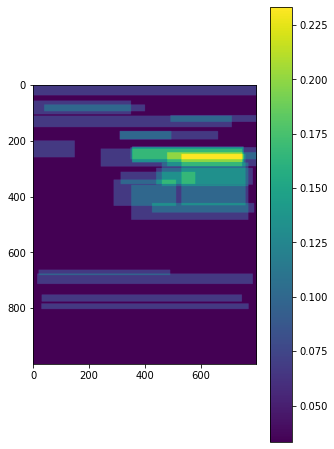

In [8]:
ups.visualize_frame(1000)

## TRAINING FOR SAMPLE DATASET - TAG BASED

In [10]:
ups.train_tag_based_model(df)

<-- Training of the tag based model has completed -->


In [11]:
ups.tags

{'a': 8,
 'dd': 1,
 'div': 11,
 'h1': 27,
 'h5': 1,
 'li': 6,
 'p': 1,
 'span': 7,
 'strong': 2}

## TRAINING FOR SAMPLE DATASET - DIMENSION BASED

In [ ]:
ups.train_dimension_based_model(df)

<-- Training of the dimension based model has completed -->


In [ ]:
ups.area

{'mean': 20418.4, 'std': 12167.837478642894}

In [ ]:
ups.predict_dimension_based_model('https://www.realme.com/in/realme-narzo-10')

[('Free shipping', 0.0017193947730398942),
 ('Secure payment', 0.0017193947730398942),
 ('Cash On Delivery', 0.0017193947730398942),
 ('© 2018-2022 realme. All Rights Reserved.', 0.0008463100880162502),
 ('realmeow\n|\nBrand\n|\nSupport\n|\nCommunity\n|\nApp\n|\nrealme Stores\n|\nBulk Order\n|\nUI 3.0',
  0.0006975446428571435)]

## TRAINING FOR SAMPLE DATASET - COMPLETE MODEL

In [13]:
ups.fit(df)

<-- Training of the dimension based model has completed -->
<-- Training of the tag based model has completed -->
<-- Training of the position based model has completed -->
<-- Model fully trained -->


In [14]:
ups.predict('https://www.realme.com/in/realme-narzo-10')

[('realme narzo-10', 0.028125),
 ('11,999', 0.011747685185185437),
 ('₹', 0.011747685185185224),
 ('Download App to Grab realme Coins !', 0.01145833333333571),
 ('Open APP', 0.011458333333333043)]

In [15]:
ups.predict('https://www.nike.com/in/t/air-jordan-1-zoom-cmft-shoes-mDxHSk/CT0978-501')

[('Air Jordan 1 Zoom Cmft', 0.02094345014249758),
 ('₹12,495\nincl. of taxes and duties', 0.01741020172191948),
 ('₹12,495', 0.011458333333333326),
 ('We think you are in United States. Update your location?\nIndia\nUnited States',
  0.009429253472218355),
 ('incl. of taxes and duties', 0.007718460648148926)]